# Quick demo of the HealPixRegridder

HealPix regridding is automatically applied during clustering for datasets with latitude/longitude coordinates.


In [1]:
# Prerequisites
import numpy as np
from toad import TOAD
from sklearn.cluster import HDBSCAN
from toad.regridding import HealPixRegridder
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from toad.shifts import ASDETECT

plt.rcParams["figure.dpi"] = 300
plt.rcParams["figure.figsize"] = (12, 5)

In [2]:
td = TOAD("test_data/global_mean_summer_tas.nc", log_level="INFO")
td.data = td.data.coarsen(lat=2, lon=2, boundary="trim").reduce(np.mean)

In [3]:
td.compute_shifts("tas", method=ASDETECT(), overwrite=True)

INFO: New shifts variable tas_dts: min/mean/max=-0.875/0.015/1.000 using 34992 grid cells. Left behind 0.0% grid cells: 0 NaN, 0 constant.


In [4]:
#  Regular latitude/longitude grids have denser sampling near the poles,
# which can bias clustering results. So for lat/lon coords, a regridder
# is applied by default: the HealPixRegridder.
regridder = HealPixRegridder()

# So you don't need to pass it, like is done here, but if you do you can also access the cluster results in the healpix grid, see 3 cells below.
td.compute_clusters(
    "tas",
    method=HDBSCAN(min_cluster_size=10),
    shift_threshold=0.6,
    overwrite=True,
    regridder=regridder,
)
# Takes 3.0 on my laptop

print(f"Identified clusters: {td.get_cluster_ids('tas')}")

INFO: New cluster variable tas_dts_cluster: Identified 13 clusters in 3,008 pts; Left behind 2.4% as noise (71 pts).


Identified clusters: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]


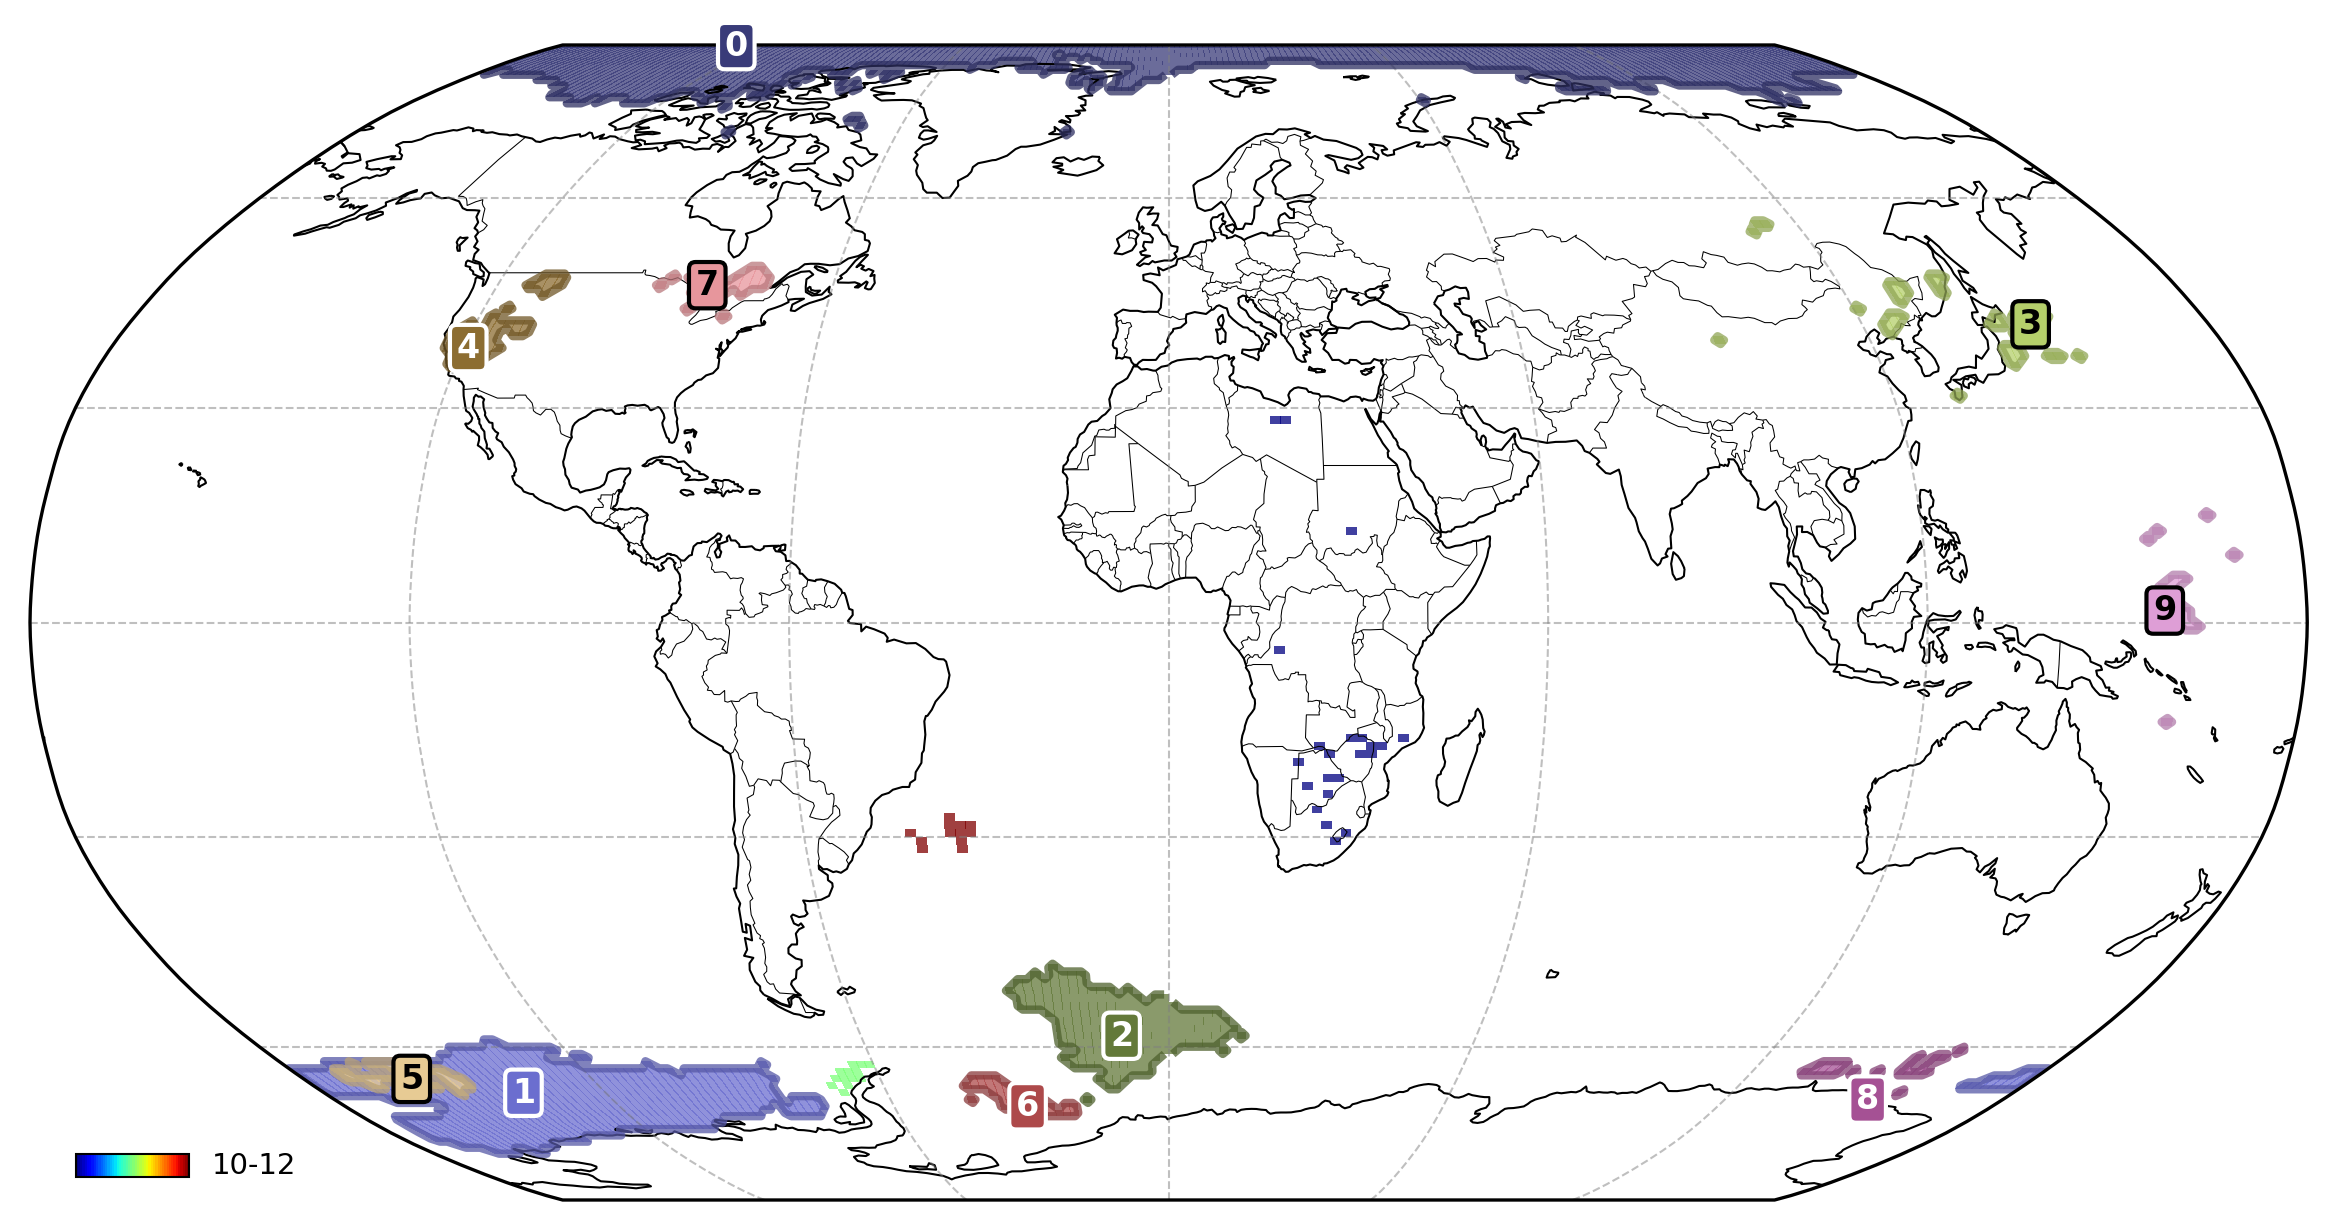

In [5]:
td.plotter().cluster_map("tas", cluster_ids=range(10), projection="global");

,time,hp_pix,vals,lat,lon,cluster
0,2023.0,46572,0.625000,-63.448284,211.250000,8
1,2024.0,35217,0.666667,-25.944480,24.609375,5
2,2024.0,36501,0.625000,-29.313199,29.531250,5
3,2024.0,36706,0.666667,-29.313199,317.812500,6
4,2024.0,36755,0.708333,-30.000000,27.421875,5
...,...,...,...,...,...,...
1590,2093.0,730,0.625000,76.077423,220.263158,2
1591,2093.0,731,0.625000,76.077423,225.000000,2
1592,2093.0,732,0.625000,76.077423,229.736842,2
1593,2093.0,733,0.666667,76.077423,234.473684,2


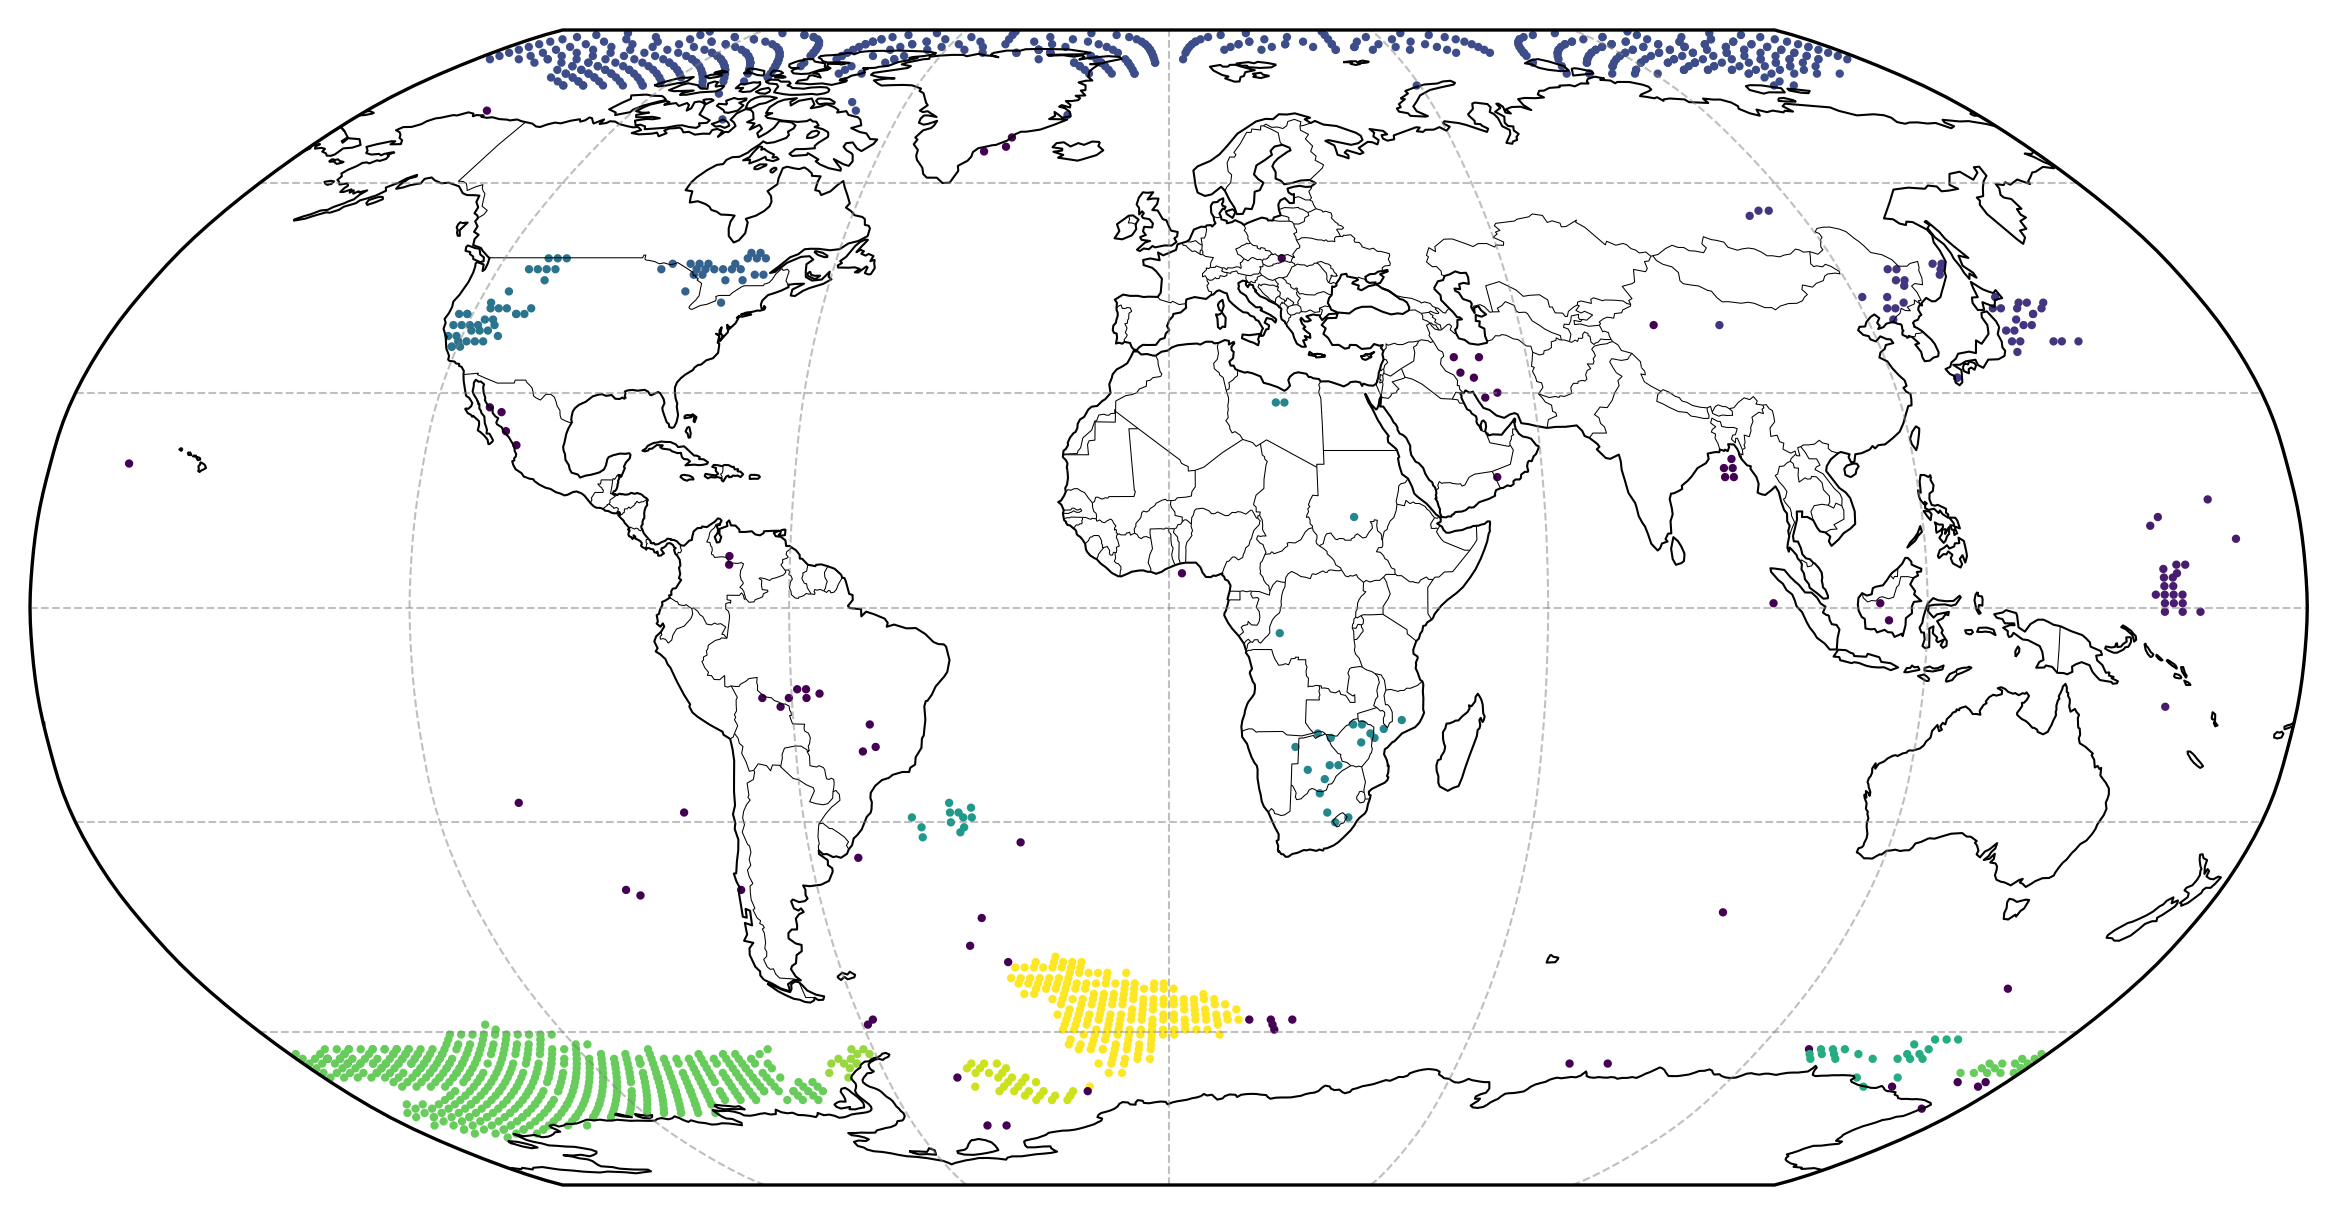

In [6]:
# we can also access the clusters in the healpix grid
display(regridder.df_healpix)

# and plot the data in the healpix grid
lats, lons, cluster = (
    regridder.df_healpix.lat,
    regridder.df_healpix.lon,
    regridder.df_healpix.cluster,
)
fig, ax = td.plotter().map(projection="global")
ax.scatter(lons, lats, c=cluster, s=1, transform=ccrs.PlateCarree())